# 1. Importing Neccesary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi   #used for radar chart
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 2. Importing Dataset

In [3]:
df = pd.read_csv(r'C:/Users/prati/Downloads/credit.csv')

In [4]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Exploring Dataset

In [5]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

#### Column SK_ID_CURR is unique row identifier and not required so we drop it.

In [6]:
df = df.drop('SK_ID_CURR', axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 283.9+ MB


#### Distribution of Loan Defulters and repayers

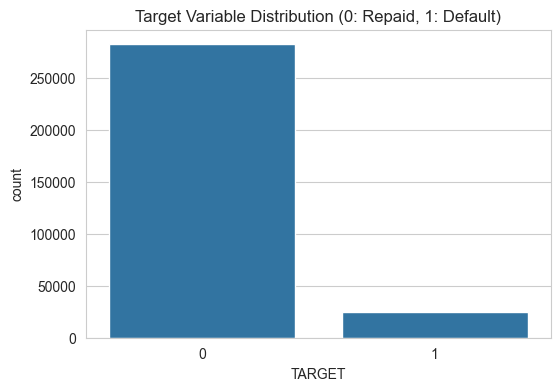

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(x='TARGET', data=df)
plt.title('Target Variable Distribution (0: Repaid, 1: Default)')
plt.show()

#### Distribution of applicant age

In [9]:
default_rate = df['TARGET'].mean() * 100
print(f"\nDefault Rate: {default_rate:.2f}% (i.e. people dont repay)")


Default Rate: 8.07% (i.e. people dont repay)


In [10]:
df['AGE_YEARS'] = df['DAYS_BIRTH'] / -365

In [11]:
df['DAYS_EMPLOYED_ANOM'] = df["DAYS_EMPLOYED"] == 365243
df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'] / -365

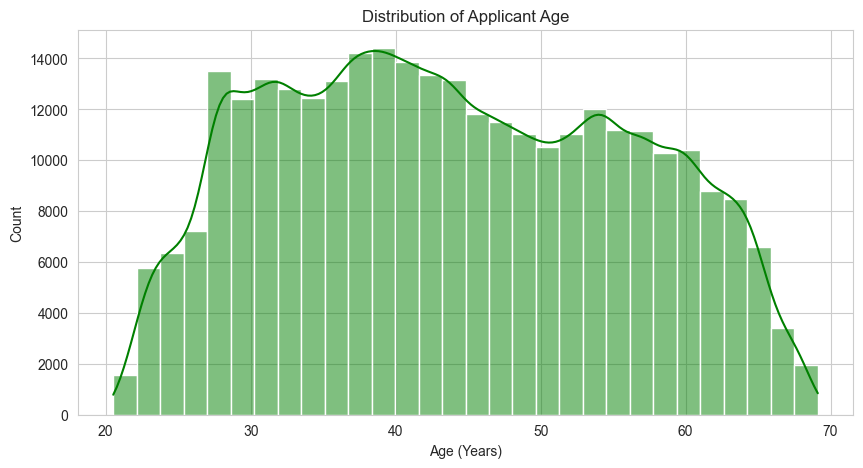

In [12]:
plt.figure(figsize=(10, 5))
sns.histplot(df['AGE_YEARS'], bins=30, kde=True, color='green')
plt.title('Distribution of Applicant Age')
plt.xlabel('Age (Years)')
plt.show()

### Co-Relation Heat map of few columns

In [13]:
correlations = df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 
                   'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']].corr()

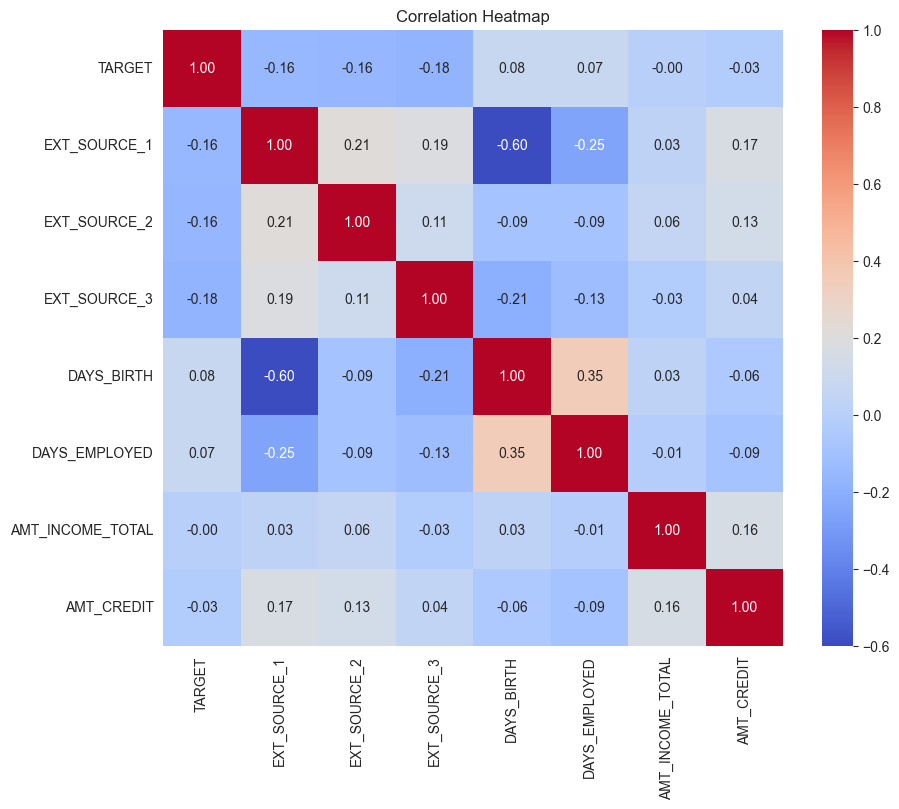

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [15]:
#### Distribution of Education level

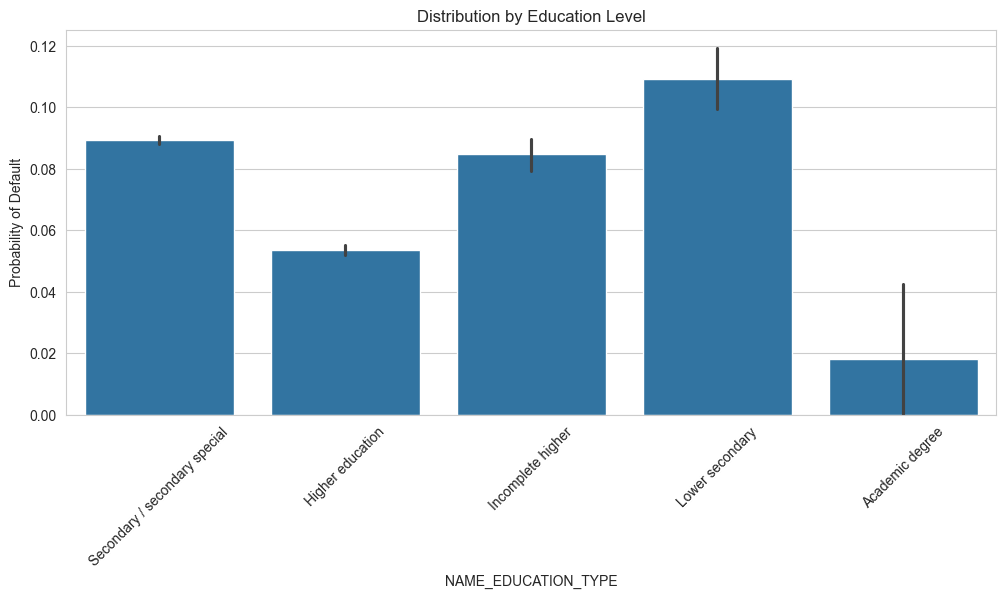

In [16]:
plt.figure(figsize=(12, 5))
sns.barplot(x='NAME_EDUCATION_TYPE', y='TARGET', data=df)
plt.title('Distribution by Education Level')
plt.xticks(rotation=45)
plt.ylabel('Probability of Default')
plt.show()

#### Income Distribution -  helps Detect Outliers

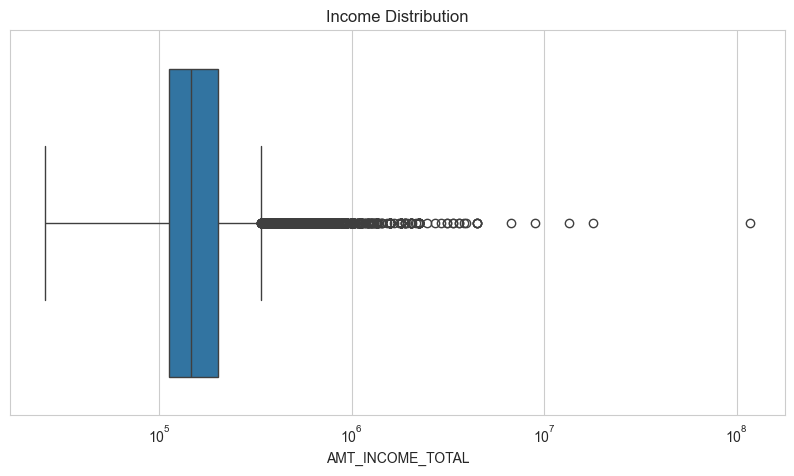

In [17]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['AMT_INCOME_TOTAL'])
plt.title('Income Distribution')
plt.xscale('log') # Log scale because income usually has massive outliers
plt.show()

In [18]:
df.isnull().sum().sum()

np.int64(9263213)

In [19]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head())

                           Total    Percent
COMMONAREA_AVG            214865  69.872297
COMMONAREA_MODE           214865  69.872297
COMMONAREA_MEDI           214865  69.872297
NONLIVINGAPARTMENTS_AVG   213514  69.432963
NONLIVINGAPARTMENTS_MEDI  213514  69.432963


#### Assets Ownership Dashboard - Distribution of applicant and assets

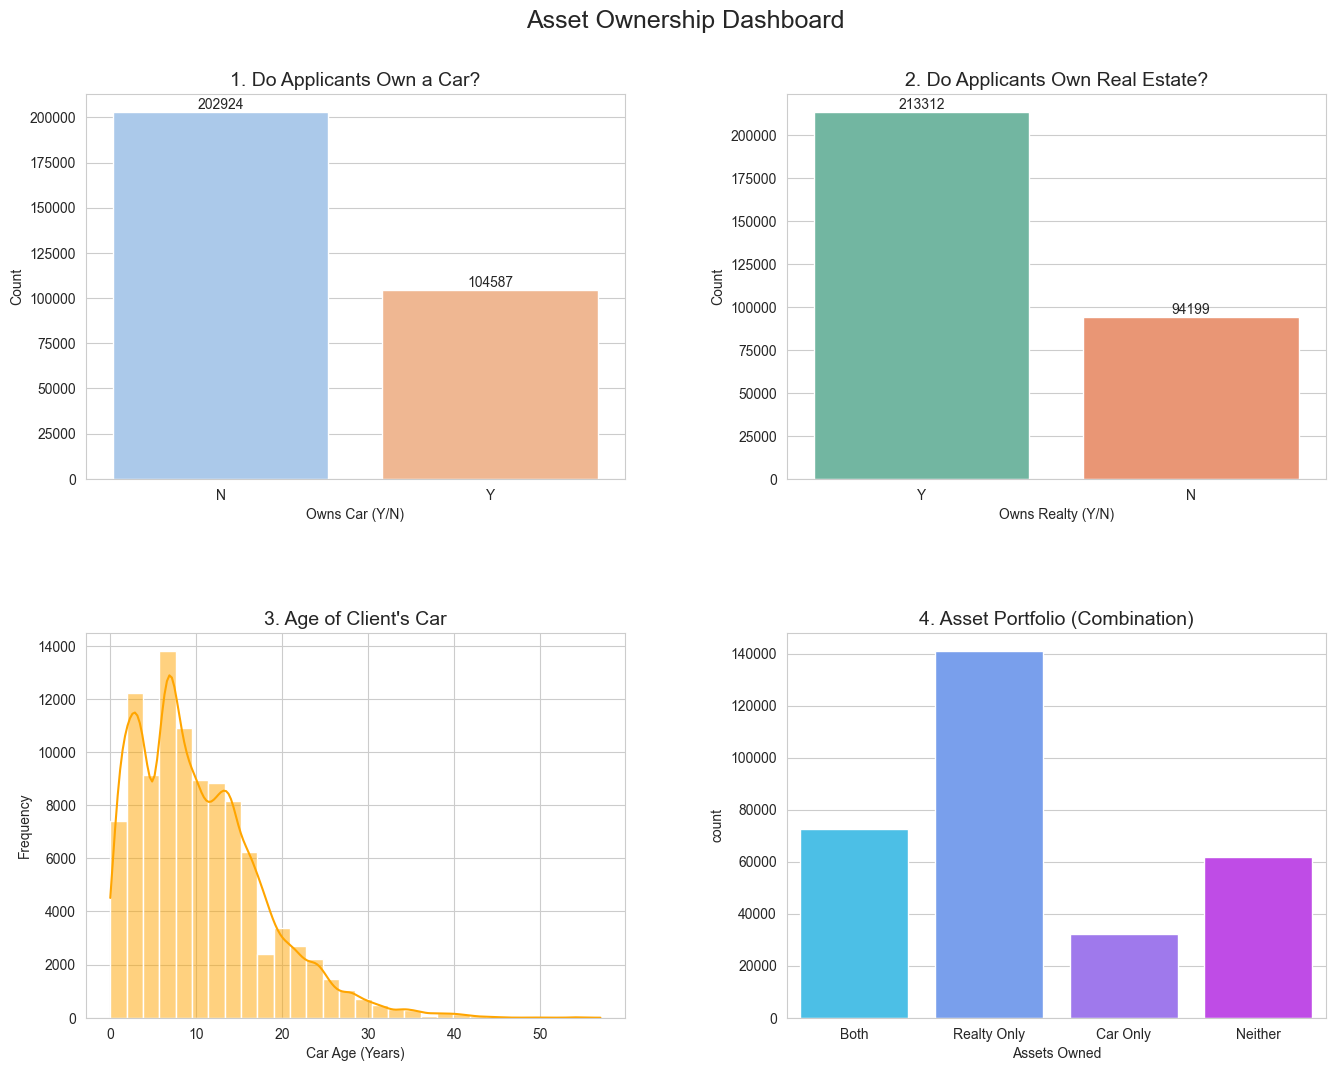

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: Car Ownership
# Y/N Flag
if 'FLAG_OWN_CAR' in df.columns:
    sns.countplot(x='FLAG_OWN_CAR', data=df, ax=axes[0, 0], palette='pastel')
    axes[0, 0].set_title('1. Do Applicants Own a Car?', fontsize=14)
    axes[0, 0].set_xlabel('Owns Car (Y/N)')
    axes[0, 0].set_ylabel('Count')
    
    # Add counts on bars
    for p in axes[0, 0].patches:
        axes[0, 0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom')

# Plot 2: Real Estate Ownership
# Y/N Flag
if 'FLAG_OWN_REALTY' in df.columns:
    sns.countplot(x='FLAG_OWN_REALTY', data=df, ax=axes[0, 1], palette='Set2')
    axes[0, 1].set_title('2. Do Applicants Own Real Estate?', fontsize=14)
    axes[0, 1].set_xlabel('Owns Realty (Y/N)')
    axes[0, 1].set_ylabel('Count')

    # Add counts on bars
    for p in axes[0, 1].patches:
        axes[0, 1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom')

# Plot 3: Age of Car (for Car Owners only)
# OWN_CAR_AGE is usually NaN if they don't own a car
if 'OWN_CAR_AGE' in df.columns:
    # Filter out NaNs and maybe unrealistic outliers (e.g. > 60 years old cars)
    car_ages = df['OWN_CAR_AGE'].dropna()
    car_ages = car_ages[car_ages < 60] 
    
    sns.histplot(car_ages, bins=30, kde=True, ax=axes[1, 0], color='orange')
    axes[1, 0].set_title('3. Age of Client\'s Car', fontsize=14)
    axes[1, 0].set_xlabel('Car Age (Years)')
    axes[1, 0].set_ylabel('Frequency')
else:
    axes[1, 0].text(0.5, 0.5, 'OWN_CAR_AGE column missing', ha='center')

# Plot 4: Asset Combination (Rich vs Poor?)
# Who owns Both vs Neither?
if 'FLAG_OWN_CAR' in df.columns and 'FLAG_OWN_REALTY' in df.columns:
    # Create a new combo column
    df['ASSET_STATUS'] = df.apply(lambda x: 
                                  'Both' if (x['FLAG_OWN_CAR'] == 'Y' and x['FLAG_OWN_REALTY'] == 'Y') else
                                  ('Car Only' if x['FLAG_OWN_CAR'] == 'Y' else 
                                  ('Realty Only' if x['FLAG_OWN_REALTY'] == 'Y' else 'Neither')), axis=1)
    
    # Sort order for consistency
    order = ['Both', 'Realty Only', 'Car Only', 'Neither']
    
    sns.countplot(x='ASSET_STATUS', data=df, ax=axes[1, 1], palette='cool', order=order)
    axes[1, 1].set_title('4. Asset Portfolio (Combination)', fontsize=14)
    axes[1, 1].set_xlabel('Assets Owned')
else:
    axes[1, 1].text(0.5, 0.5, 'Asset columns missing', ha='center')

plt.suptitle('Asset Ownership Dashboard', fontsize=18, y=0.95)
plt.show()

#### Radar Chart of the living house space - gives basic idea of how big house is comapred to surrounding area

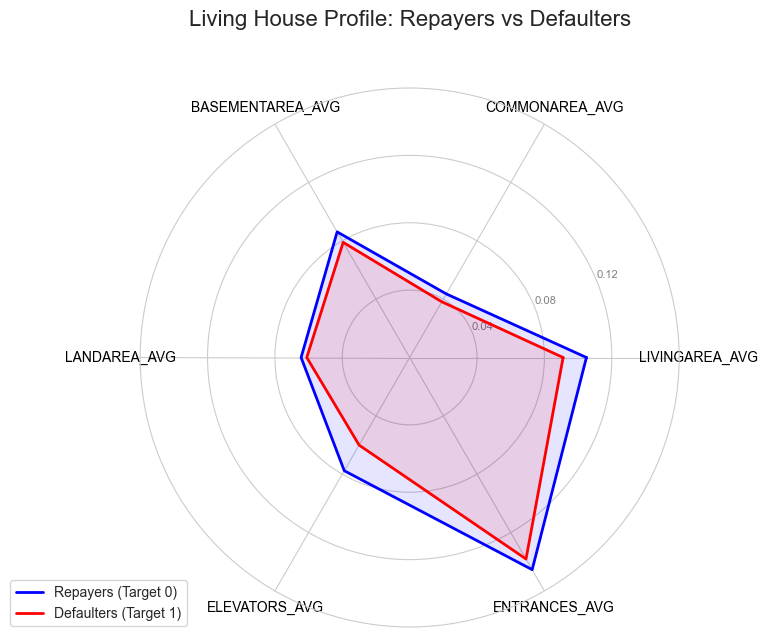

In [21]:
features = ['LIVINGAREA_AVG', 'COMMONAREA_AVG', 'BASEMENTAREA_AVG', 
            'LANDAREA_AVG','ELEVATORS_AVG', 'ENTRANCES_AVG']

# Check if these columns exist in your dataset before proceeding
missing_cols = [col for col in features if col not in df.columns]
if missing_cols:
    print(f"Warning: The following columns are missing and will be skipped: {missing_cols}")
    features = [c for c in features if c not in missing_cols]

# Group by TARGET to compare Repayers (0) vs Defaulters (1)
# We use .mean() to get the average profile
house_stats = df.groupby('TARGET')[features].mean().reset_index()
# --- 3. Create the Radar Chart (Auto-Scaling) ---
categories = features
N = len(categories)

# Calculate angles for the spokes
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1] # Close the loop

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

# Draw the axis labels (names of columns)
plt.xticks(angles[:-1], categories, color='black', size=10)

# AUTO-SCALE LOGIC: Find the max value in the data to set limits dynamically
# We take the maximum average value found in the summary to set the outer ring
max_val = house_stats[categories].max().max()
# Add a little buffer (10%) so the line doesn't hit the very edge
limit = max_val * 1.1 

# Draw grid lines based on this dynamic limit
yticks = [limit * 0.25, limit * 0.5, limit * 0.75]
plt.yticks(yticks, [f"{y:.2f}" for y in yticks], color="grey", size=8)
plt.ylim(0, limit)

# Plot Repayers (Target 0)
if 0 in house_stats['TARGET'].values:
    values_0 = house_stats.loc[house_stats['TARGET'] == 0, categories].values.flatten().tolist()
    values_0 += values_0[:1]
    ax.plot(angles, values_0, linewidth=2, linestyle='solid', label='Repayers (Target 0)', color='blue')
    ax.fill(angles, values_0, 'blue', alpha=0.1)

# Plot Defaulters (Target 1)
if 1 in house_stats['TARGET'].values:
    values_1 = house_stats.loc[house_stats['TARGET'] == 1, categories].values.flatten().tolist()
    values_1 += values_1[:1]
    ax.plot(angles, values_1, linewidth=2, linestyle='solid', label='Defaulters (Target 1)', color='red')
    ax.fill(angles, values_1, 'red', alpha=0.1)

plt.title('Living House Profile: Repayers vs Defaulters', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()

#### Family background Dashboard - Show the distribution of applicant according to the family background.

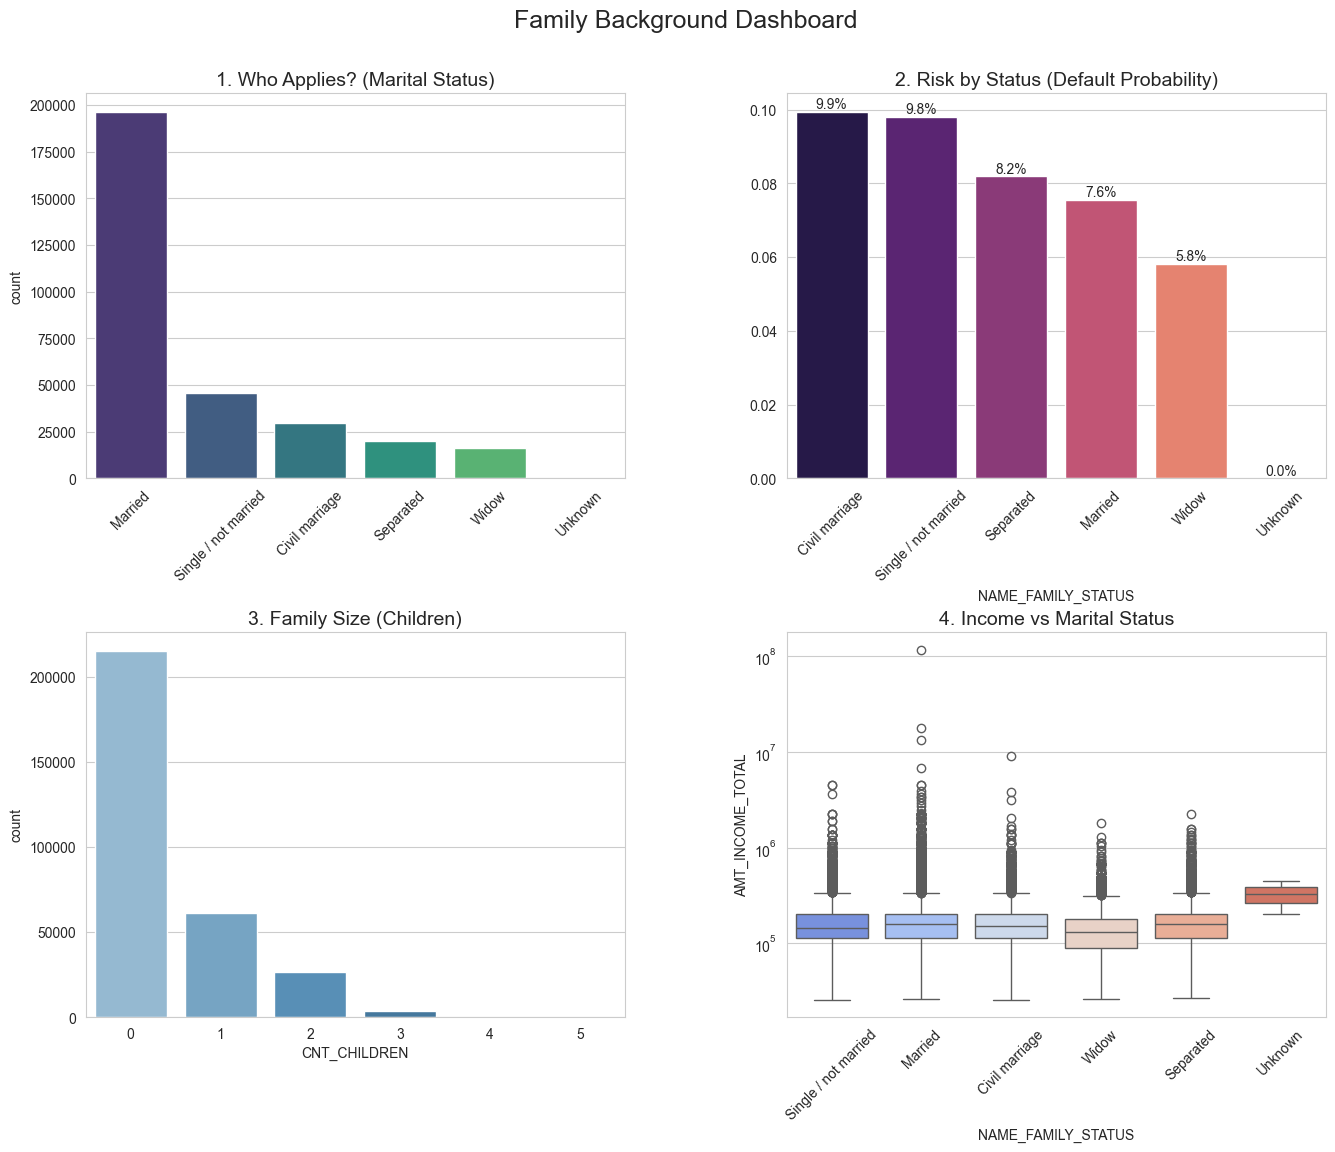

In [22]:
df.columns = df.columns.str.strip()
target_col = 'NAME_FAMILY_STATUS'


# --- VISUALIZATION CODE (Safe Version) ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Plot 1: Marital Status
sns.countplot(x=target_col, data=df, ax=axes[0, 0], 
              palette='viridis', order=df[target_col].value_counts().index)
axes[0, 0].set_title('1. Who Applies? (Marital Status)', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_xlabel('')

# Plot 2: Default Rate by Marital Status
# Only run if TARGET exists
if 'TARGET' in df.columns:
    default_by_status = df.groupby(target_col)['TARGET'].mean().sort_values(ascending=False)
    sns.barplot(x=default_by_status.index, y=default_by_status.values, ax=axes[0, 1], palette='magma')
    axes[0, 1].set_title('2. Risk by Status (Default Probability)', fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Add labels
    for i, v in enumerate(default_by_status.values):
        axes[0, 1].text(i, v, f'{v:.1%}', ha='center', va='bottom')
else:
    axes[0, 1].text(0.5, 0.5, 'TARGET column missing', ha='center')

# Plot 3: Children (Clip to < 6)
if 'CNT_CHILDREN' in df.columns:
    sns.countplot(x='CNT_CHILDREN', data=df[df['CNT_CHILDREN'] < 6], ax=axes[1, 0], palette='Blues_d')
    axes[1, 0].set_title('3. Family Size (Children)', fontsize=14)
else:
    axes[1, 0].text(0.5, 0.5, 'CNT_CHILDREN column missing', ha='center')

# Plot 4: Income vs Status
if 'AMT_INCOME_TOTAL' in df.columns:
    sns.boxplot(x=target_col, y='AMT_INCOME_TOTAL', data=df, ax=axes[1, 1], palette='coolwarm')
    axes[1, 1].set_title('4. Income vs Marital Status', fontsize=14)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].set_yscale('log')
else:
    axes[1, 1].text(0.5, 0.5, 'AMT_INCOME_TOTAL column missing', ha='center')

plt.suptitle('Family Background Dashboard', fontsize=18, y=0.95)
plt.show()

# 4. Null values Handling

In [23]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

for column in categorical_columns:
    cardinality = len(df[column].unique())
    print(f"Column: {column}, Cardinality: {cardinality}, \nvalues: {df[column].unique()}\n\n")

Column: NAME_CONTRACT_TYPE, Cardinality: 2, 
values: ['Cash loans' 'Revolving loans']


Column: CODE_GENDER, Cardinality: 3, 
values: ['M' 'F' 'XNA']


Column: FLAG_OWN_CAR, Cardinality: 2, 
values: ['N' 'Y']


Column: FLAG_OWN_REALTY, Cardinality: 2, 
values: ['Y' 'N']


Column: NAME_TYPE_SUITE, Cardinality: 8, 
values: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']


Column: NAME_INCOME_TYPE, Cardinality: 8, 
values: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']


Column: NAME_EDUCATION_TYPE, Cardinality: 5, 
values: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']


Column: NAME_FAMILY_STATUS, Cardinality: 6, 
values: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']


Column: NAME_HOUSING_TYPE, Cardinality: 6, 
values: ['House / apartment' 'Rented apartment' 'With pa

#### DAYS_EMPLOYED column has the value 365243 repetatively which tells that this man is retired. so we replace these values with na and then with mean

In [44]:
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

In [25]:
df.CODE_GENDER.replace('xna','F', inplace=True)

In [26]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [27]:
print(f"Original Features Shape: {X.shape}")

Original Features Shape: (307511, 124)


In [28]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [29]:
imputer_num = SimpleImputer(strategy='median')
X[numeric_cols] = imputer_num.fit_transform(X[numeric_cols])

In [30]:
X[categorical_cols] = X[categorical_cols].fillna('Unknown')

In [31]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# 5. Standardization

In [32]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
X_final = pd.DataFrame(X_scaled, columns=X.columns)

# 6. Splitting the dataset for train, test

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
print(X_train.iloc[:5, :5])

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
181648      2.192084         -0.332309   -0.923019    -0.960365   
229245     -0.577538         -0.332309   -1.086476    -0.966885   
122525     -0.577538         -0.142533    0.322545    -0.055300   
306311     -0.577538         -0.142533   -0.310177     0.519408   
300658     -0.577538          0.047242   -0.855489     0.031015   

        AMT_GOODS_PRICE  
181648        -0.970289  
229245        -1.092145  
122525         0.041116  
306311        -0.397565  
300658        -0.848433  


# 7. Model building - A simple neural network.

In [36]:
model = Sequential()

model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.3))


model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=16, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

#### Hyper Parameter Tuning

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

print(model.summary())

In [38]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,          # Maximum number of runs through the data
    batch_size=256,     # How many rows to process at once
    callbacks=[early_stop],
    verbose=1
)

In [46]:
# 8. Evaluation Metrics

In [40]:
loss, accuracy, auc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy:.2f}")
print(f"Test AUC Score: {auc:.2f}")


Test Accuracy: 0.92
Test AUC Score: 0.75


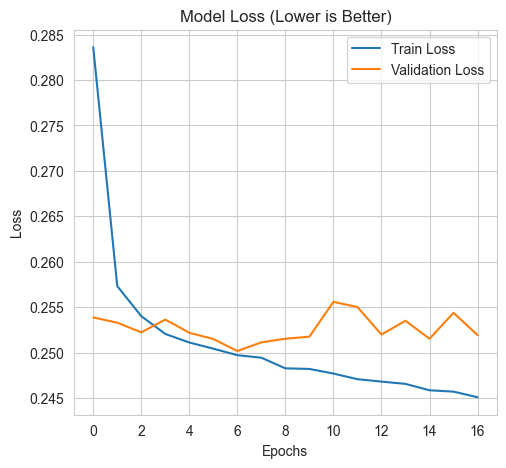

In [41]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Lower is Better)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

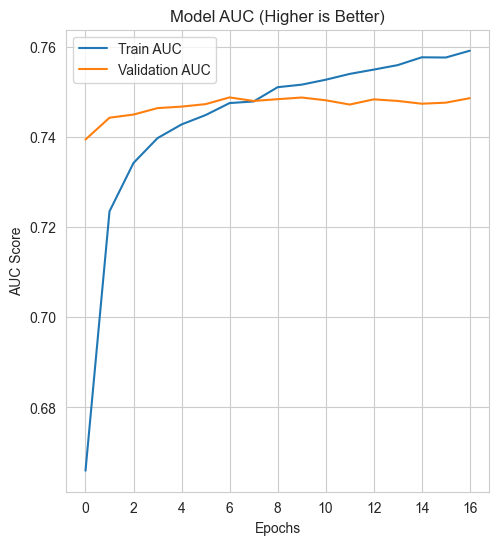

In [42]:
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC (Higher is Better)')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.legend()

plt.show()